## Adapting the “Learning PyTorch with Examples” Regression Tutorial to Predict Diabetes Progression
- EAI6010
> Ayush Anand

In [1]:
# Install & import libraries
# (In Colab, torch and sklearn are usually pre-installed) still intalling as a preliminary steps as per pytorch tutorial i was going through
!pip install torch torchvision scikit-learn --quiet

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import SGD
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import random

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 30.0 MB/s eta 0:00:00


In [2]:
# Reproducibility ───────────────────────────────────────────────────────────
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [3]:
# Load & preprocess the Diabetes dataset ───────────────────────────────────
data = load_diabetes()
X, y = data.data, data.target.reshape(-1, 1)
scaler_X = StandardScaler().fit(X)
scaler_y = StandardScaler().fit(y)

X_scaled = scaler_X.transform(X)
y_scaled = scaler_y.transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=SEED)

In [4]:
# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32)

In [5]:
# Define a simple feed-forward network ─────────────────────────────────────
class DiabetesModel(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

model = DiabetesModel(in_features=X_train.shape[1])

In [6]:
# Loss and optimizer ───────────────────────────────────────────────────────
criterion = nn.MSELoss()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

In [15]:
# ── 1. Modify your training loop to record loss history ─────────────────────────
loss_history = []
epoch_list   = []

EPOCHS = 100
for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_ds)

    # record
    loss_history.append(avg_loss)
    epoch_list.append(epoch)

    if epoch % 20 == 0:
        print(f'Epoch {epoch:3d} – Train MSE: {avg_loss:.4f}')


Epoch  20 – Train MSE: 0.3977
Epoch  40 – Train MSE: 0.4830
Epoch  60 – Train MSE: 0.2623
Epoch  80 – Train MSE: 0.3364
Epoch 100 – Train MSE: 0.2936


In [16]:
# Evaluation ───────────────────────────────────────────────────────────────
model.eval()
with torch.no_grad():
    preds = model(X_test_t).numpy()
    true  = y_test_t.numpy()
    mse_test = ((preds - true)**2).mean()
print(f'Test MSE (scaled): {mse_test:.4f}')


Test MSE (scaled): 0.5473


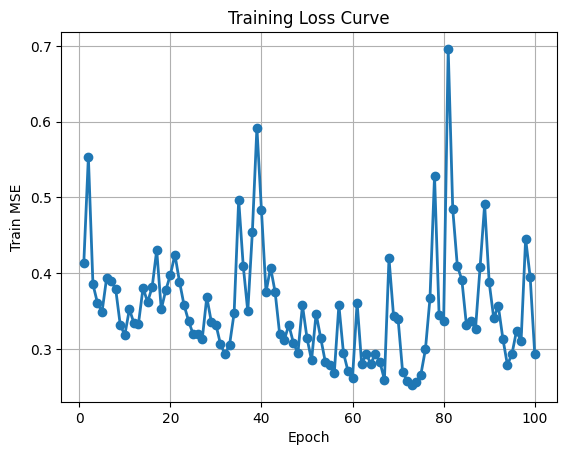

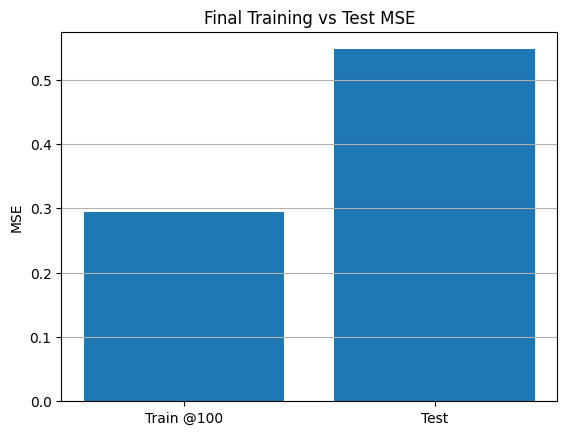

In [17]:
# ── 2. Plot training-loss curve and train vs. test MSE ─────────────────────────
import matplotlib.pyplot as plt

# a) Training Loss Curve
plt.figure()
plt.plot(epoch_list, loss_history, marker='o', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Train MSE')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

# b) Final Train vs Test MSE
final_train_mse = loss_history[-1]
test_mse        = mse_test  # from your evaluation cell

plt.figure()
plt.bar(['Train @100', 'Test'], [final_train_mse, test_mse])
plt.ylabel('MSE')
plt.title('Final Training vs Test MSE')
plt.grid(axis='y')
plt.show()


Test R²: 0.387


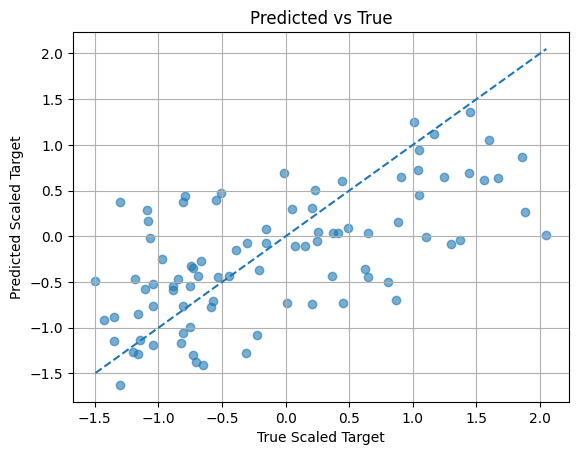

In [18]:
# ── 3. Scatter plot and R² on test set ─────────────────────────────────────────
from sklearn.metrics import r2_score

model.eval()
with torch.no_grad():
    preds = model(X_test_t).numpy().flatten()
    true  = y_test_t.numpy().flatten()

# R²
r2 = r2_score(true, preds)
print(f'Test R²: {r2:.3f}')

# Predicted vs True scatter
plt.figure()
plt.scatter(true, preds, alpha=0.6)
plt.plot([true.min(), true.max()], [true.min(), true.max()], '--')
plt.xlabel('True Scaled Target')
plt.ylabel('Predicted Scaled Target')
plt.title('Predicted vs True')
plt.grid(True)
plt.show()
